# ANALISIS DE RENDIMIENTO ESTUDIANTES

### Robinson Niño Placencia

### Importo las librerias a utlizar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
%matplotlib inline

### Creo el dataframe

* Agrego **sep=';'** para que me muestre una correcta visualizacion de los datos

In [2]:
df = pd.read_csv('hespe-data.csv',sep=';')

In [3]:
df.head(2)

,student_id,age,sex,graduated_h_school_type,scholarship_type,additional_work,activity,partner,total_salary,transport,...,preparation_midterm_company,preparation_midterm_time,taking_notes,listenning,discussion_improves_interest,flip_classrom,grade_previous,grade_expected,course_id,grade
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1


### Analisis de nulos

* Obsevamos que no hay valores nulos en el dataframe.
* La unica variable que es tipo objeto es **student_id**, como este parametro no es relevante, será el primero a descartar.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   student_id                    145 non-null    object
 1   age                           145 non-null    int64 
 2   sex                           145 non-null    int64 
 3   graduated_h_school_type       145 non-null    int64 
 4   scholarship_type              145 non-null    int64 
 5   additional_work               145 non-null    int64 
 6   activity                      145 non-null    int64 
 7   partner                       145 non-null    int64 
 8   total_salary                  145 non-null    int64 
 9   transport                     145 non-null    int64 
 10  accomodation                  145 non-null    int64 
 11  mother_ed                     145 non-null    int64 
 12  farther_ed                    145 non-null    int64 
 13  siblings            

In [5]:
df.isnull().sum()

student_id                      0
age                             0
sex                             0
graduated_h_school_type         0
scholarship_type                0
additional_work                 0
activity                        0
partner                         0
total_salary                    0
transport                       0
accomodation                    0
mother_ed                       0
farther_ed                      0
siblings                        0
parental_status                 0
mother_occup                    0
father_occup                    0
weekly_study_hours              0
reading_non_scientific          0
reading_scientific              0
attendance_seminars_dep         0
impact_of_projects              0
attendances_classes             0
preparation_midterm_company     0
preparation_midterm_time        0
taking_notes                    0
listenning                      0
discussion_improves_interest    0
flip_classrom                   0
grade_previous

### Boxplot

* No se observan valores atipicos.

<Axes: ylabel='grade'>

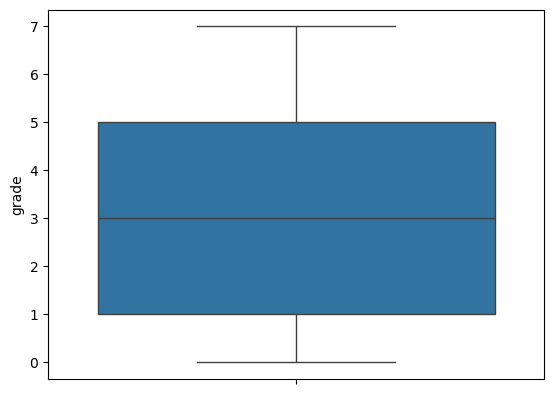

In [6]:
sns.boxplot(df['grade'])

### Matriz de correlacion

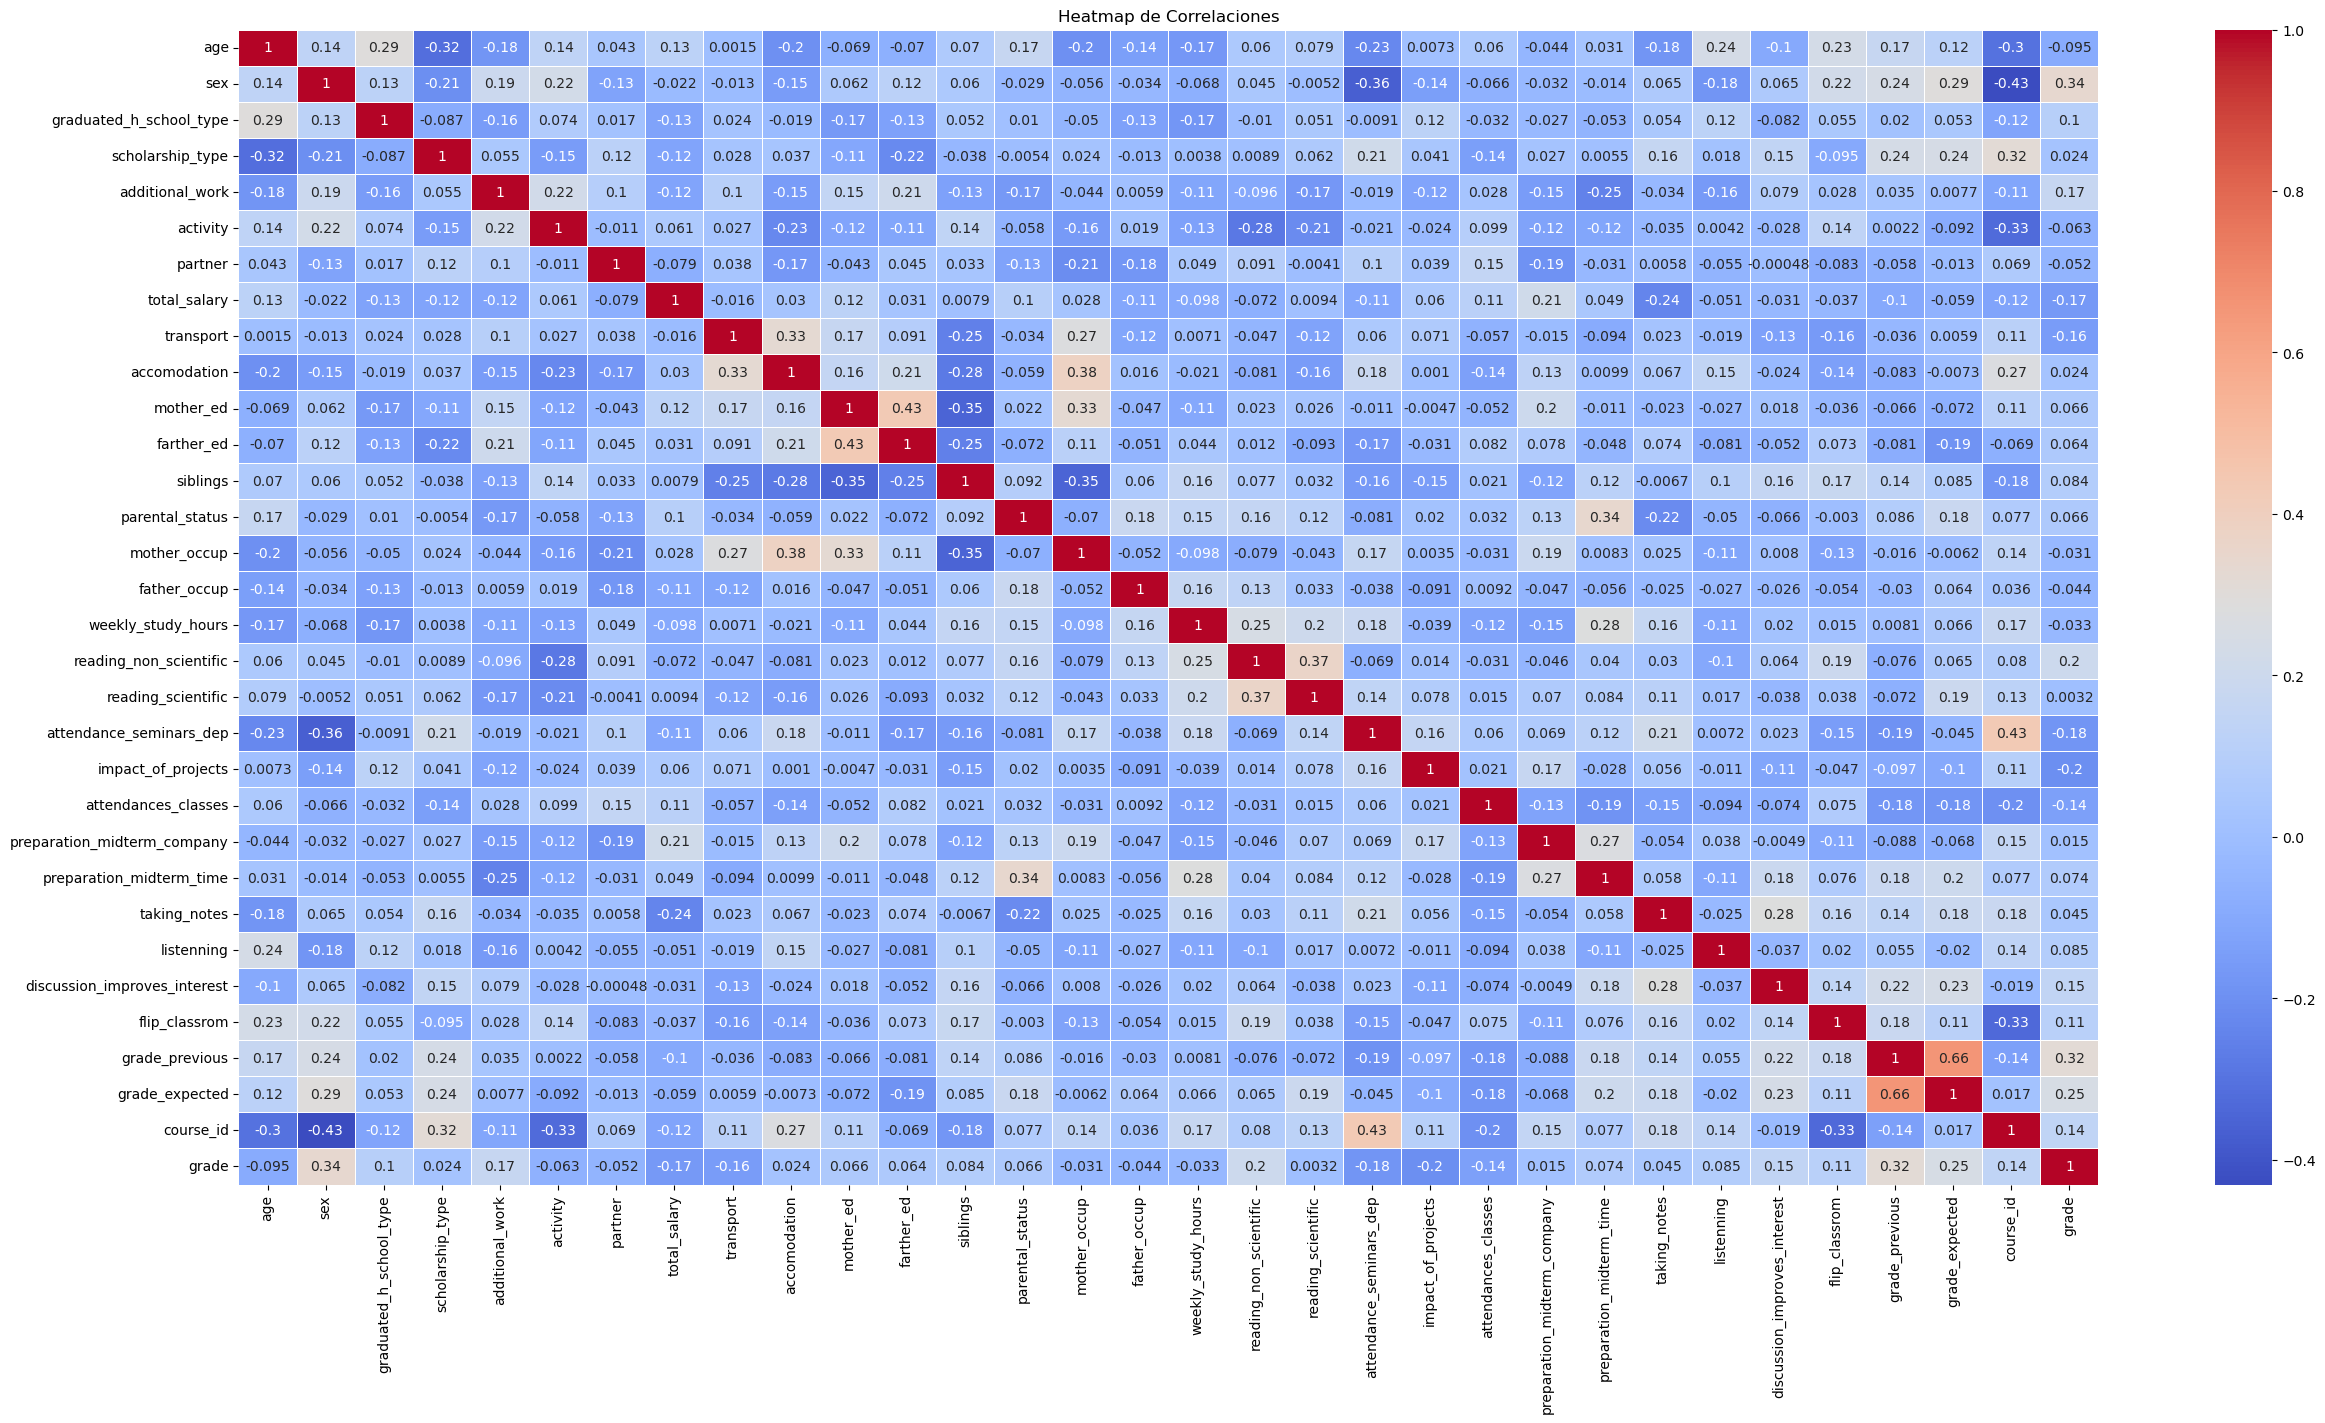

In [7]:
correlation_matrix = df.drop(['student_id'],axis=1).corr()#Elimino la variable 'student_id'
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de Correlaciones')
plt.show()

### Tabla de correlacion

In [8]:
# Convierto la matriz de correlacion en un dataframe
corr_df = correlation_matrix.stack().reset_index()
corr_df.columns = ['Feature 1', 'Feature 2', 'Correlacion']

# Filtro para que Feature 2 solo contenga el parametro'grade'
corr_df = corr_df[corr_df['Feature 2'] == 'grade']

# Ordeno por el valor de la correlacion
corr_df = corr_df.sort_values(by='Correlacion', ascending=False)
print(corr_df)

                         Feature 1 Feature 2  Correlacion
1023                         grade     grade     1.000000
63                             sex     grade     0.335533
927                 grade_previous     grade     0.315493
959                 grade_expected     grade     0.248588
575         reading_non_scientific     grade     0.195617
159                additional_work     grade     0.167445
863   discussion_improves_interest     grade     0.146547
991                      course_id     grade     0.142166
895                  flip_classrom     grade     0.110617
95         graduated_h_school_type     grade     0.104821
831                     listenning     grade     0.085137
415                       siblings     grade     0.084470
767       preparation_midterm_time     grade     0.073783
447                parental_status     grade     0.066379
351                      mother_ed     grade     0.066318
383                     farther_ed     grade     0.063504
799           

### Eligiendo Features

* Podría usar la matriz de correlacion, y elegir los mejores caracteres que yo piense que puedan influir guiandome por su valor.
  Pero hacer esto es muy poco intuitivo.
* Por lo que durante el modelamiento del modelo buscare los mejores Features usando SelectorSequentialModel, junto a XgBoostClassifier.
* Probare modelos que usen entre 10 y 20 Features en los cuales me quedare con el que tenga mejor **Accuracy**
* Uso un modelo de clasificacion ya que los datos entregados es de dicho caso. No hablamos de valores numericos como el valor de una casa,
  sino mas bien estos valores numericos entregados en el csv son categoricos.

### Formulacion del modelo

In [9]:
#Elimino el feature 'student_id' junto a 'grade' de X
X=df.drop(['student_id','grade'],axis=1)

#Mi target sera 'grade'
y=df['grade']

### Validacion Cruzada

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
#Dejare un 75% de datos de entranamiento y un 25% de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### Modelamiento XGBoost y SequentialFeatureSelector

* Use un modelo de ensamble ya que combina modelos sencillos para hacer uno fuerte.
* XGBoost reduce el sobreajuste y mejora la generalización del modelo.
* es conocido por su eficiencia y velocidad de entrenamiento.


#### Para este primer intento, probare primero con 10 Features.

In [13]:
#Defino mi modelo a utilizar
from xgboost import XGBClassifier
model = XGBClassifier()

#Defino la cantidad de features a utilizar
#Mi modelo ira agregando features hasta encontrar el mas optimo guiandose del accuracy
sfs = SequentialFeatureSelector(model, n_features_to_select=10, direction='forward', scoring='accuracy', cv=5)

#Ajusto el selector a los datos de entrenamiento
sfs.fit(X_train, y_train)

#Transformo los datos de entrenamiento y prueba
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

#Finalmente entreno el modelo con los features seleccionados
model.fit(X_train_sfs, y_train)

#Obtengo el accuracy
accuracy = model.score(X_test_sfs, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.35135135135135137


* Obtuvimos un **Accuracy** de 0.35, ¿mejorara con 20 features?

#### Segundo intento, 20 features

In [14]:
#Defino mi modelo a utilizar
model = XGBClassifier()

#Defino la cantidad de features a utilizar
#Mi modelo ira agregando features hasta encontrar el mas optimo guiandose del accuracy
sfs = SequentialFeatureSelector(model, n_features_to_select=20, direction='forward', scoring='accuracy', cv=5)

#Ajusto el selector a los datos de entrenamiento
sfs.fit(X_train, y_train)

#Transformo los datos de entrenamiento y prueba
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

#Finalmente entreno el modelo con los features seleccionados
model.fit(X_train_sfs, y_train)

#Obtengo el accuracy
accuracy = model.score(X_test_sfs, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.2972972972972973


* Al agregar mas features, nuestro resultado disminuyo, por lo que agregar parametros no mejora nuestro modelo.
  ¿Y con 15 features?.

#### Tercer intento, 15 features

In [15]:
#Defino mi modelo a utilizar
model = XGBClassifier()

#Defino la cantidad de features a utilizar
#Mi modelo ira agregando features hasta encontrar el mas optimo guiandose del accuracy
sfs = SequentialFeatureSelector(model, n_features_to_select=15, direction='forward', scoring='accuracy', cv=5)

#Ajusto el selector a los datos de entrenamiento
sfs.fit(X_train, y_train)

#Transformo los datos de entrenamiento y prueba
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

#Finalmente entreno el modelo con los features seleccionados
model.fit(X_train_sfs, y_train)

#Obtengo el accuracy
accuracy = model.score(X_test_sfs, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.3783783783783784


* Obtuvimos una buena mejora, aumento a 0.37, ¿Y con 14 Features?.

#### Cuarto Intento, 14 features

In [16]:
#Defino mi modelo a utilizar
model = XGBClassifier()

#Defino la cantidad de features a utilizar
#Mi modelo ira agregando features hasta encontrar el mas optimo guiandose del accuracy
sfs = SequentialFeatureSelector(model, n_features_to_select=14, direction='forward', scoring='accuracy', cv=5)

#Ajusto el selector a los datos de entrenamiento
sfs.fit(X_train, y_train)

#Transformo los datos de entrenamiento y prueba
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

#Finalmente entreno el modelo con los features seleccionados
model.fit(X_train_sfs, y_train)

#Obtengo el accuracy
accuracy = model.score(X_test_sfs, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.40540540540540543


* Con 14 Features obtuvimos un Accuracy de 0.40, Seguire probando quitando features.

#### Quinto Intento, 13 features

In [17]:
#Defino mi modelo a utilizar
model = XGBClassifier()

#Defino la cantidad de features a utilizar
#Mi modelo ira agregando features hasta encontrar el mas optimo guiandose del accuracy
sfs = SequentialFeatureSelector(model, n_features_to_select=13, direction='forward', scoring='accuracy', cv=5)

#Ajusto el selector a los datos de entrenamiento
sfs.fit(X_train, y_train)

#Transformo los datos de entrenamiento y prueba
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

#Finalmente entreno el modelo con los features seleccionados
model.fit(X_train_sfs, y_train)

#Obtengo el accuracy
accuracy = model.score(X_test_sfs, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.40540540540540543


* Con 13 features no hay cambios, por lo que hemos hallado los 13 parametros que optimizan el modelo.
* pd: Se que son 13 features porque cuando lo realice con 12 el accuracy disminuyo. No quise agregar esa parte porque
  me toma tiempo ejecutar la celda por el coste computacional. Y quise que el quinto intento sea mi ultima ejecucion.

### Extrayendo los features

In [18]:
#Identifico los features seleccionados por el modelo
selected_features = sfs.get_support()

#Identifico las columnas de mi dataframe
feature_names = X.columns

#En este ciclo for in basicamente busca las que coincida el features seleccionado por el modelo como con el del dataframe inicial.
#Intento hacer coincidir los valores True booleanos con su respectiva etiqueta en X.columns
selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selected_features[i]]
#Muestro las columnas
print(f'Selected features: {selected_feature_names}')

Selected features: ['age', 'sex', 'graduated_h_school_type', 'partner', 'mother_ed', 'parental_status', 'weekly_study_hours', 'reading_scientific', 'attendance_seminars_dep', 'impact_of_projects', 'preparation_midterm_time', 'grade_previous', 'course_id']


### Compruebo si esas columnas estan bien

* Repito, pero ahora con las columnas de X definidas, el costo computacional de esto ya es mucho menor.

In [19]:
#Defino mis variables de feature y target

X=df[['age', 'sex', 'graduated_h_school_type', 'partner', 'mother_ed', 'parental_status', 'weekly_study_hours', 
      'reading_scientific', 'attendance_seminars_dep', 'impact_of_projects', 'preparation_midterm_time', 'grade_previous', 'course_id']]
y=df['grade']

#Realizo la cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#defino mi variable con el modelo a utilizar
xgb = XGBClassifier()

#entreno los datos
xgb.fit(X_train,y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [20]:
# score en set de entrenamiento
xgb.score(X_train,y_train)

1.0

In [21]:
# score en set de test
xgb.score(X_test,y_test)

0.40540540540540543

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = xgb.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')


Accuracy: 0.40540540540540543
Recall: 0.40540540540540543
Precision: 0.3981981981981982
F1 Score: 0.39094899094899094


Aqui es posible observar dos cosas del set de datos de entrenamiento y prueba:

* En el set de entrenamiento tenemos un accuracy de 1.0 (¿Posible sobreajuste?)
* En el set de prueba tenemos un accuracy de 0.40, que corresponde al valor calculado anteriormente, por lo que nuestros features estan en lo correcto.

### Accuracy en otros modelos

### Random Forest

In [23]:
#Importo las librerias a usar
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


#Defino mi variable con el modelo con 200 arboles de decision
rfc=RandomForestClassifier(n_estimators=200)

#Realizo la cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#Realizo el ajuste
rfc.fit(X_train,y_train)

#Defino la prediccion
rfc_predictions=rfc.predict(X_test)


#Obtengo el Accuracy sobre los datos de prueba
print("Accuracy:", accuracy_score(y_test, rfc_predictions))


Accuracy: 0.40540540540540543


* Accuracy baja a 0.35

### Gradient Boosting

In [24]:
#Importo las librerias a usar
from sklearn.ensemble import GradientBoostingClassifier

#Defino mi variable con el modelo
gbc = GradientBoostingClassifier(random_state=0)

#Realizo la cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#Realizo el ajuste
gbc.fit(X_train,y_train)



,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [25]:
# score en set de entrenamiento
gbc.score(X_train,y_train)

1.0

In [26]:
# score en set de test
gbc.score(X_test,y_test)

0.2972972972972973

* Accuracy baja a 0.29
* Finalmente decido quedarme con XGBoost ya que tiene mejor rendimiento.
* Intentare seguir mejorando el modelo
* Usare tanto RandomSearch como GridSearch, mas adelante vere que con GridSearch obtuve mejores parametros para mejorar mi modelo, a costa de rendimiento computacional.

Ahora buscare la forma de mejorar el modelo por medio de los ajustes a los hiperparametros

### Randomnizando los hiperparametros

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# Definir los parámetros a ajustar
# Simplemente elegi trabajar con ese rango de parametros por simple aletoriedad.
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2,0.3,0.4],
    'max_depth': [2,3, 4, 5, 6, 7, 8],
    'subsample': [0.4,0.5,0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4,0.5,0.6, 0.7, 0.8, 0.9, 1.0]
}

# Crear el modelo
model = xgb.XGBClassifier(random_state=0)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, 
                                   scoring='accuracy', cv=6, verbose=1, random_state=42, n_jobs=-1)

# Ajustar el modelo
random_search.fit(X_train, y_train)

# Imprimir los mejores parámetros
print("Mejores hiperparámetros:", random_search.best_params_)

# Predecir en el conjunto de prueba
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")


Fitting 6 folds for each of 50 candidates, totalling 300 fits


/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. R

Mejores hiperparámetros: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Accuracy: 0.38
Precision: 0.36
Recall: 0.38
F1-Score: 0.37
AUC-ROC: 0.74


* Los hiperparametros encontrados no tienen una gran mejoria que digamos, basandome en el parametro Accuracy.

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
clf = GradientBoostingClassifier(random_state=0)

In [30]:
clf.fit(X_train,y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [31]:
from sklearn.model_selection import train_test_split

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

# Escalar los datos de entrenamiento y prueba
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


from sklearn.linear_model import LogisticRegression
# Entrenamiento del modelo con los datos escalados
model = LogisticRegression(max_iter=500)
model.fit(X_train_scaled, y_train)

# Realizar la predicción sobre el conjunto de prueba escalado
predictions = model.predict(X_test_scaled)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Matriz de confusión y reporte de clasificación
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

[[0 2 2 0 0 0 0 0]
 [0 0 3 0 0 0 0 0]
 [0 1 1 1 0 1 0 0]
 [0 0 1 1 0 3 1 0]
 [0 1 1 0 0 1 0 0]
 [0 1 0 1 0 1 0 0]
 [0 0 1 1 0 1 0 1]
 [0 0 0 1 0 0 0 1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         3
           2       0.11      0.25      0.15         4
           3       0.20      0.17      0.18         6
           4       0.00      0.00      0.00         3
           5       0.14      0.33      0.20         3
           6       0.00      0.00      0.00         4
           7       0.50      0.50      0.50         2

    accuracy                           0.14        29
   macro avg       0.12      0.16      0.13        29
weighted avg       0.11      0.14      0.11        29

Accuracy: 0.13793103448275862


/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

### Grid Search

In [32]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier


# Definir el modelo y los hiperparámetros a buscar
# Simplemente elegi trabajar con ese rango de parametros por simple aletoriedad.
model = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100, 200,300],
    'max_depth': [3, 4, 5, 6,7,8],
    'learning_rate': [0.01, 0.1, 0.2,0.5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', 
                           cv=5, n_jobs=-1, verbose=2)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best accuracy: {grid_search.best_score_}')


# Hacer predicciones con el mejor modelo encontrado
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")



Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END colsamp

/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1

/home/apolo/anaconda3/envs/scikit-learn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Los hiperparametros que mejoran el Accuracy hasta un 47% (datos de entrenamiento) son los siguientes:

* colsample_bytree=1.0
* learning_rate=0.1
* max_depth=4
* n_estimators=100
* subsample=0.8

Reemplazare mis parametros de forma directa en mi modelo XGBoost.

In [33]:
#defino mi variable con el modelo a utilizar
xgb = XGBClassifier(colsample_bytree=1.0,learning_rate=0.1,max_depth=4,n_estimators=100,subsample=0.8)

#entreno los datos
xgb.fit(X_train,y_train)

#Realizo las predicciones
y_pred=xgb.predict(X_test)

### Matriz de confusion

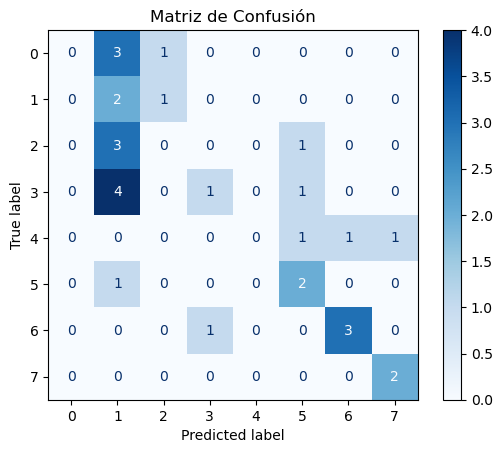

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

De la matriz de confusion observo lo siguiente, cuyos datos fuera de la diagonal puede deberse
a lo siguiente:

* Puede que mi modelo no este con los features adecuados.
* El modelo utilizado tambien no puede ser el adecuado.
* Los hiperparametros hallados puede que no sean los mas optimos.
* Posiblemente hallan clases mas predominantes que otras.

### Curva ROC

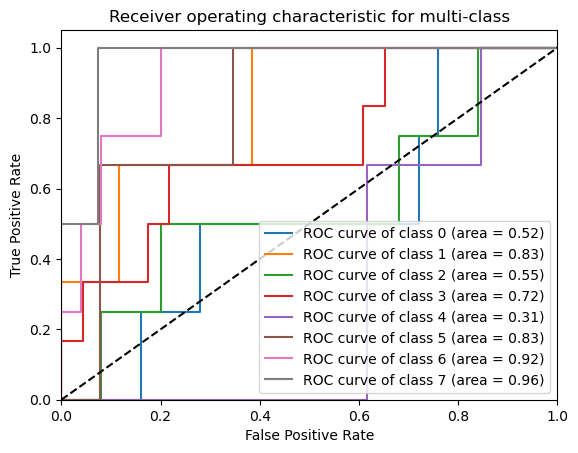

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Binarizo las etiquetas
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Calculo la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Grafio las curvas ROC
plt.figure()
for i in range(n_classes):
  plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
           ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

De la curva ROC observo lo siguiente:

* Para la clase 1 y clase 2, mi modelo tiene un rendimiento pobre.
* Para la clase 3 tiene un rendimiento aceptable.
* Para la clase 0, clase 4 y clase 5 tiene buen rendimiento.
* Para la clase 6 y 7 tiene un rendimiento excelente.

Mis conclusiones:

* El modelo es ineficiente, solo predice mas o menos la mitad de las clases (grades) de buena forma, mientras que la otra mitad esta con errores.

* Solo lo usaria para predecir la poblacion que reprueba (clase 0), o que obtiene buenas calificaciones (clase 5 para arriba.)

* El modelo logra un mayor accuracy para los datos de entrenamiento que para los de prueba, ampliar los datos puede que mejore los resultados.
